## Introduction

A health tech company called **‘BeHealthy’**. They aim to connect the medical communities with millions of patients across the country. 
BeHealthy has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

### Problem Statement

**BeHealthy** require <font color = 'blue'>**predictive model**</font> which can <font color = 'green'>**identify disease and treatment**</font> from the patients interaction with doctor or ordering medicines online

### Observation

- Here, idea is to extract the **useful information** from text and in addition to that the **entity of the useful information** also need to be identified. 
- Because the information we are planning to extract from the statement/interactions between doctor and patients are related to medical terms which are not regular usage day-to-day words.





### Approach

- By observing the requirement, it is clearly visible that we have to process the textual sentence and identify the entities like **Disease and Treatment**. We can predict these all requirements using 
        -  CRF (Conditional Random Field) classifier
        -  Random Forest Classifier
        -  HMM (Hidden Markov Model)

#### Model Explanation
1. For Medical Entity Recognition, we are building CRF model which uses custom NER becuase the entities we are planning to recognise all are related to medical terminologies.
2. Luckily!! we received dataset which contains sentences along with labels, labels/tags are very important for Entity recognition. *If your dataset is not labelled, you have to manually label the data for Model Building and Prediction*.

#### Dataset Explanation
We have four data file for this activity to proceed, they are
1. Train Sentence Dataset
2. Train Label Dataset
3. Test Sentence Dataset
4. Test Label Dataset

Sentence file contains all interations between patients and doctor and Label file contains all enitiy tags for particular words arranged as per sentence. We need to do few preprocessing while accessing dataset we will explore that in further steps

#### Library Explanation
1. Pandas - Dataframe, Content storage and processing
2. Regular Expression (re) - Identify the textual pattern
3. SpaCy - NLP, POS tag check
4. Warnings - To avoid warning messages
5. Sklearn_CRFsuite - Model building and Evaluation

## Libraries  and Packages

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1898 sha256=a4377d0e89362a83426621bcec54877f8658697a04dcbd3663f0d01d2bed9a9f
  Stored in directory: /root/.cache/pip/wheels/0b/68/37/a457e156cfd6174ed28c9c8cb76f18eeb559b760d84c0a22eb
Successfully built pycrf
     |████████████████████████████████| 743 kB 284 kB/s 


In [2]:
# Library Import
import pandas as pd
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

## Common Functions

### Preprocessing Functions

In [3]:
# Extract sentence from words
def content_extract(file_path='',sep='\t'):
    '''It helps to extract the word based on the separator to form the sentence'''
    try:
        with open (file_path,'r',encoding='utf-8') as text:
            if text.mode  == 'r':
                content = text.readlines()
        sentence = []
        final_sentence=''
        for c in content:
            content_word = c.strip('\n')
            if content_word == '':
                #Once it get matched with separator, it appends previous extracted concatenated string as sentence
#                 final_sentence = re.sub('(?<=[\(]) | (?=[%\',)])','', final_sentence)
                sentence.append(final_sentence.strip(' '))

                #Initialize for next sentence
                final_sentence=''
            else:
                # Till the loop identifies the separator it concatenates string
                final_sentence+=content_word+' '
        print('Total identified value: ',len(sentence),'\n')
        print('Sample display value:\n',sentence[:5])
        return sentence
    except FileNotFoundError:
        print('Check and provide proper file path')

### Post-processing functions

In [4]:
# A class to retrieve the sentences details from the dataframe
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

### Feature Extraction

In [5]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['EOS'] = True

    return features

In [6]:
# Define a function to extract features for a sentence.
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [7]:
# Define a function to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

## Task for Approach

- Data Preprocessing (EDA)
- Observation of POS Tag and Repeated word frequencies for feature identification
- Create feature function and extract feature from each sentence
- Prepare input and Target variable for model
- Build CRF model
- Evaluate model using F1-score
- Predict disease and treatment 

## EDA

### Pre-processing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

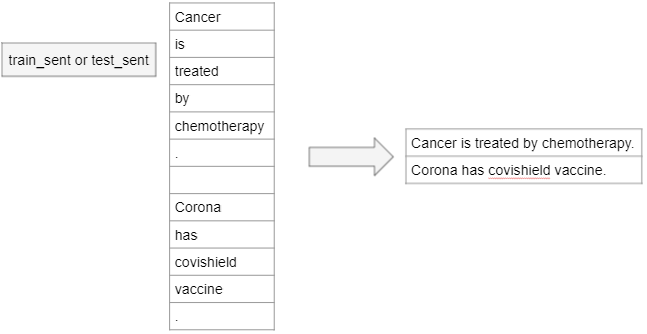

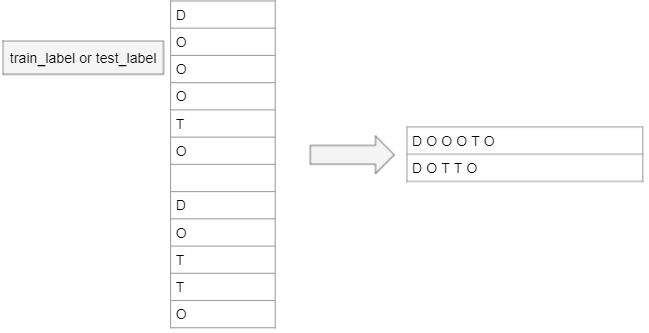

The above dataset is about the labels corresponding to the diseases and the treatment. There are three labels that have been used in this dataset: **O, D and T**, which are corresponding to **Other**, <font color = 'red'>**Disease**</font> and <font color = 'blue'>**Treatment**</font>, respectively.

In [8]:
# Train sentence extraction from dataset
train_sent = content_extract(file_path='../input/medical-entity-recognition-ner/Dataset/train_sent',sep='\n')

Total identified value:  2599 

Sample display value:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]


In [9]:
# Train label extraction from dataset
train_label = content_extract(file_path='../input/medical-entity-recognition-ner/Dataset/train_label',sep='\n')

Total identified value:  2599 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [10]:
# Test sentence extraction from dataset
test_sent = content_extract(file_path='../input/medical-entity-recognition-ner/Dataset/test_sent',sep='\n')

Total identified value:  1056 

Sample display value:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


In [11]:
# Test label extraction from dataset
test_label = content_extract(file_path='../input/medical-entity-recognition-ner/Dataset/test_label',sep='\n')

Total identified value:  1056 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


### Extract POS information using SpaCy

In [12]:
# Import spacy small library to find medical related entities
nlp= spacy.load("en_core_web_sm")

In [13]:
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [14]:
#train datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(train_sent,train_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [15]:
#test datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(test_sent,test_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

### Frequence of words for POS tag as NOUN & PROPN

In [16]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
freq_df = pd.DataFrame()
freq_df = pd.concat((train_df,test_df),axis=0)

In [17]:
# Resetting index
freq_df.reset_index(inplace=True,drop=True)

In [18]:
# Top 25 most frequency values for Train and Test related dataset words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           162
disease         143
cell            140
lung            116
group            94
chemotherapy     88
gene             88
effects          85
results          79
use              78
women            77
patient          74
risk             71
cases            71
surgery          71
analysis         70
rate             67
response         66
survival         65
associated       64
Name: word, dtype: int64

In [19]:
# Top 25 most frequency values for Train and Test related lemma words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

patient         576
treatment       316
%               247
study           240
cancer          226
cell            203
effect          182
therapy         182
disease         164
group           145
case            131
lung            118
gene            112
rate            103
trial            91
woman            89
chemotherapy     88
analysis         86
result           83
protein          82
response         81
year             79
child            78
use              78
risk             78
Name: lemma, dtype: int64

### Dataframe (Sentence, word, POS) visualisation

In [20]:
train_df.head(5)

,sentence,word,lemma,pos,label
0,1,All,all,DET,O
1,1,live,live,VERB,O
2,1,births,birth,NOUN,O
3,1,>,>,X,O
4,1,or,or,CCONJ,O


In [21]:
test_df.head(5)

,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,ADV,O
3,1,all,all,DET,O
4,1,deliveries,delivery,NOUN,O


### Sentense-wise detail dataframe preparation 

In [22]:
# Fetch detail view of sentence for train set
train_sent_obj = sentencedetail(train_df)
train_sent_detail = train_sent_obj.sentences

In [23]:
# Display one sentence detail view for train set
train_sent_detail[0]

[('All', 'DET', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'X', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'PUNCT', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'DET', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'X', 'O'),
 ('=', 'PUNCT', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'PROPN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'PROPN', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'NOUN', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'ADP', 'O'),
 ('reflect', 'VER

In [24]:
# Fetch detail view of sentence for train set
test_sent_obj = sentencedetail(test_df)
test_sent_detail = test_sent_obj.sentences

In [25]:
# Display one sentence detail view for train set
test_sent_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'ADV', 'O'),
 ('all', 'DET', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'ADJ', 'O'),
 ('to', 'ADP', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'X', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'PUNCT', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'DET', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'AUX', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'ADJ', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('1994', 'NUM', 

## Input and Target Variable

In [26]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent2features(s) for s in train_sent_detail]
X_test = [sent2features(s) for s in test_sent_detail]

In [27]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent2labels(l) for l in train_sent_detail]
y_test = [sent2labels(l) for l in test_sent_detail]

## Building CRF model using sklearn

In [28]:
# Build the CRF model.
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

# fit the model
crf.fit(X_train, y_train)

CRF(all_possible_transitions=False, c1=1.0, c2=0.01, keep_tempfiles=None,
    max_iterations=100)

## Evaluate model (F1-score)

In [29]:
# Calculate the f1 score using the test data
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 91.51 % 


## Predict Disease and Treatment

In [30]:
# Taken out predicted label from the model
pred_label=[]
for i in y_pred:
    pred_label.extend(i)

In [31]:
# Loaded into test dataframe
test_df['label_predicted'] = pred_label

In [32]:
# Visualise top 5 data
test_df.head(5)

,sentence,word,lemma,pos,label,label_predicted
0,1,Furthermore,furthermore,ADV,O,O
1,1,",",",",PUNCT,O,O
2,1,when,when,ADV,O,O
3,1,all,all,DET,O,O
4,1,deliveries,delivery,NOUN,O,O


### Dictionary Preparation

In [33]:
# Preparing dictionary by keeping Disease as unique Key element and Treatment as value element
new_df =test_df[(test_df['label_predicted'] != 'O')]
new_df.set_index('sentence',inplace=True)
disease=[]
treatment=[]
sentence=[]
med_dict = {}
for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'label_predicted'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df['label_predicted'] == 'D'].loc[i,'word']
            treatment_val = new_df[new_df['label_predicted'] == 'T'].loc[i,'word']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

In [34]:
print(med_dict)

{'gestational diabetes cases': 'good glycemic control', 'nonimmune hydrops fetalis': 'Trisomy', 'epilepsy': 'Methylphenidate', 'unstable angina or non - Q - wave myocardial infarction': 'roxithromycin', 'coronary - artery disease': 'Antichlamydial antibiotics', 'primary pulmonary hypertension ( PPH )': 'fenfluramines', 'essential hypertension': 'moxonidine', 'foot infection': 'G - CSF treatment', 'hemorrhagic stroke': 'double - bolus alteplase alteplase ( P=0.24', 'cardiac disease': 'fenfluramine - phentermine', 'rheumatoid arthritis': 'arthrodesis', "early Parkinson 's disease": 'Ropinirole monotherapy', 'sore throat': 'Antibiotics', 'female stress urinary incontinence': 'surgical treatment', 'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination', 'severe acquired hyperammonemia cancer': 'organ transplantation and chemotherapy', 'major pulmonary embolism': 'thrombolytic treatment', 'malignant pleural mesothelioma': 't

In [35]:
#Predict treatment withthe help of dictionary
d=[]
disease=''
test_sent=[]
treatment=''

input_sent = 'Rahul suffering from advanced rectal cancer'
m = spacy.load('en_core_web_sm')
doc = m(input_sent)
for i in doc:
    d.append((i.text,i.pos_,'D'))
test_sent.append(sent2features(d))
for i,tag in enumerate(crf.predict(test_sent)[0]):
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr
        if tr in med_dict:
            treatment += ''+med_dict.get(tr)
if len(treatment) == 0:
    treatment='None'
print('Identified Disease: ',disease)
print('Identified Treatment: ', treatment)

Identified Disease:  rectalcancer
Identified Treatment:  Matrix metalloproteinase inhibitors


## Model weight Visulisation using eli5

In [36]:
# Import
import eli5

In [37]:
# Show top 30 weights of model across all labels
eli5.show_weights(crf,top=30)